In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import spearmanr

import networkx as nx

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import os
from os import system
import sys
sys.path.append('../')

from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

from lib.import_funcs import *
import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as figfunc
import lib.funcs_raster as funcs_raster

import gzip

%load_ext autoreload
%autoreload 2

In [2]:
path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/" # for Mac
path_data = path+"DATA/"
# genes of OUR dataset
genes = np.loadtxt(path_data+'general_info/all_genes_list.csv', dtype="str")
cells = np.loadtxt(path_data+'general_info/all_cells_list.csv', dtype="str")
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# Selected genes order
genes_order = np.concatenate((naive, formative, committed))
nc_genes = np.setdiff1d(imp_genes, genes_order)
genes_order = np.concatenate((genes_order, nc_genes))
genes_order

array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Nanog',
       'Sox2', 'Nr0b1', 'Zic3', 'Rbpj', 'Utf1', 'Etv4', 'Tcf15', 'Dnmt3a',
       'Dnmt3b', 'Lef1', 'Otx2', 'Pou3f1', 'Etv5', 'Gbx2', 'Pou5f1',
       'Sall4', 'Tcf7l1'], dtype='<U7')

0.0


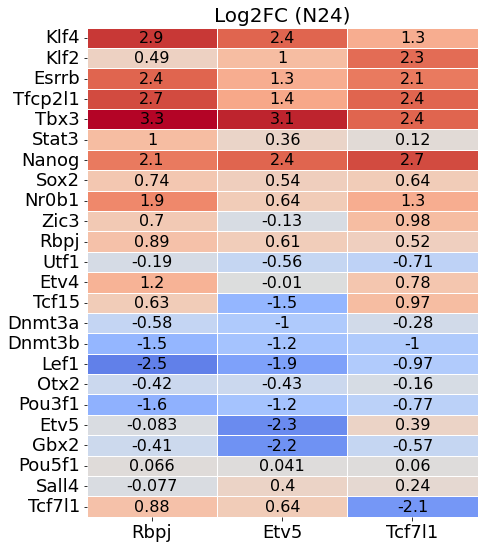

In [3]:
def InteractionList(path="LogFC_Leeb.csv", perc=0):
    df = pd.read_csv(path, sep=";", index_col=0).reindex(genes_order)
    df.iloc[:,:] = df.iloc[:,:].replace(',', '.', regex=True).astype(float)
    thr = np.abs(df.max().max()*perc)
    print(thr)
    output = []
    for row in df.index:
        for col in df.columns:
            element = df.loc[row, col]
            if element > thr:
                sign = "1"
            elif element < -thr:
                sign = "-1"
            else:
                df.loc[row, col] = 0
                sign = "0"
#             if (sign == "-1") or (sign == "1"):
            output.append(f"{col} {row} {sign}")
    return(output, df)

Interactions_list, df = InteractionList(path=path_data+"Leeb_Data_Downloaded/LogFC_Leeb.csv")

plt.figure(figsize=(7,9))
sns.heatmap(np.array(df).astype(float), annot=True, fmt="g", 
            xticklabels=df.columns, yticklabels=df.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (N24)", fontsize=20)
plt.show()

# print(1-len(Interactions_list)/( df.shape[0]*df.shape[1]))

# From Data

In [4]:
with gzip.open(path_data+'Leeb_Data_Downloaded/GSE145653_batch_info.csv.gz', 'rt') as f:
     KO_info_Leeb = pd.read_csv(f)
with gzip.open(path_data+'Leeb_Data_Downloaded/GSE145653_FPKM_KOs.csv.gz', 'rt') as f:
    KO_data_Leeb = pd.read_csv(f)

KO_data_Leeb = KO_data_Leeb.set_index('Unnamed: 0')
KO_data_Leeb.index.name=None
KO_data_Leeb.head()

,L11734,L11735,L11736,L11737,L11738,L11739,L11740,L11741,L11742,L11743,...,L13223,L13224,LL54673,LL54676,LL54678,LL54677,LL54674,LL54672,LL54679,LL54675
Xkr4,0.096358,0.035534,0.029169,0.025106,0.048925,0.115725,0.050539,0.017693,0.042993,0.092945,...,0.093787,0.125737,0.031907,0.082746,0.018832,0.032812,0.035440,0.052645,0.049301,0.083473
Sox17,0.011634,0.028316,0.103305,0.044458,0.064977,0.040985,0.089496,0.082244,0.128475,0.000000,...,0.062280,0.528809,0.211879,0.170949,0.125055,0.101682,0.047068,0.237723,0.130954,0.221722
Mrpl15,117.455010,99.933964,104.444733,113.550707,115.627292,113.816006,121.124725,124.826020,120.809614,116.759976,...,101.674287,104.675866,101.025859,103.702246,99.454823,110.103175,108.696011,125.732550,115.975846,120.408831
Lypla1,213.152308,189.660275,210.889568,193.478648,197.102432,212.492995,195.756074,204.591414,216.076858,219.256884,...,135.058628,131.235656,192.493799,142.244180,186.263766,159.898945,238.295539,184.107767,253.559324,175.816072
Tcea1,22.267539,22.098032,27.141503,20.904960,22.349934,22.429507,22.222399,21.940010,24.273013,22.567348,...,35.624346,35.177925,17.090382,21.347559,17.026751,20.794196,17.422555,23.194043,19.225913,23.196378


## WT

In [5]:
wt_rbpj_info = KO_info_Leeb.loc[KO_info_Leeb['ko_gene'] == "RC9"]
wt_rbpj_info

,sample,name,time,ko_gene,RNABatch
315,LL54674,LL54674_2i_RC9,2i,RC9,8
316,LL54672,LL54672_N1_RC9,N1,RC9,8
317,LL54679,LL54679_2i_RC9,2i,RC9,8
318,LL54675,LL54675_N1_RC9,N1,RC9,8


In [6]:
wt_ge = KO_data_Leeb[wt_rbpj_info["sample"]]
wt_ge.columns = wt_rbpj_info["name"]

wt_ge.head(3)

name,LL54674_2i_RC9,LL54672_N1_RC9,LL54679_2i_RC9,LL54675_N1_RC9
Xkr4,0.035440,0.052645,0.049301,0.083473
Sox17,0.047068,0.237723,0.130954,0.221722
Mrpl15,108.696011,125.732550,115.975846,120.408831


In [7]:
wt_ge = wt_ge.iloc[:,[1,3]]
wt_ge=wt_ge[wt_ge.index.isin(genes_order)]

wt_ge.head(3)

name,LL54672_N1_RC9,LL54675_N1_RC9
Gbx2,34.961149,39.386600
Tfcp2l1,224.947252,209.903764
Tcf15,71.346463,73.981594


In [8]:
wt_ge_mean = pd.DataFrame(wt_ge.mean(axis=1)).reindex(genes_order)

wt_ge_mean.head(2)

,0
Klf4,17.672967
Klf2,41.576515


## KO Rpbj

In [9]:
KO_rbpj_info = KO_info_Leeb.loc[KO_info_Leeb['ko_gene'] == "Rbpj"]

KO_rbpj_ge = KO_data_Leeb[KO_rbpj_info["sample"]]
KO_rbpj_ge.columns = KO_rbpj_info["name"]
KO_rbpj_ge.head(3)

name,166_i_Rbpj,167_i_Rbpj,200_N1_Rbpj,201_N1_Rbpj
Xkr4,0.007298,0.036828,0.077221,0.056945
Sox17,0.019385,0.012228,0.051279,0.088234
Mrpl15,80.956853,84.327395,77.274928,76.604270


In [10]:
KO_rbpj_ge = KO_rbpj_ge.iloc[:,2:]
KO_rbpj_ge.head(3)

name,200_N1_Rbpj,201_N1_Rbpj
Xkr4,0.077221,0.056945
Sox17,0.051279,0.088234
Mrpl15,77.274928,76.604270


In [11]:
KO_rbpj_ge=KO_rbpj_ge[KO_rbpj_ge.index.isin(genes_order)]
KO_rbpj_ge_mean = pd.DataFrame(KO_rbpj_ge.mean(axis=1))

KO_rbpj_ge_mean = KO_rbpj_ge_mean.reindex(genes_order)

KO_rbpj_ge_mean.head(3)

,0
Klf4,50.872853
Klf2,33.273905
Esrrb,83.398445


In [12]:
diff_Leeb = np.squeeze(np.sign(KO_rbpj_ge_mean/wt_ge_mean))

logFC_Leeb = np.squeeze(np.log2(KO_rbpj_ge_mean/wt_ge_mean))

logFC_Leeb_t = df

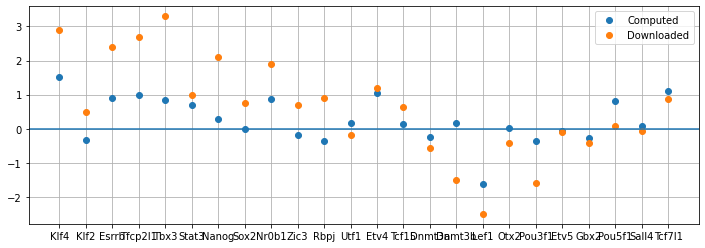

In [13]:
plt.figure(figsize=(12,4))
plt.plot(logFC_Leeb, "o", label="Computed")
plt.plot(logFC_Leeb_t["Rbpj"], "o", label="Downloaded")
plt.legend()
plt.grid()
plt.axhline(0)

In agreement: 0.6666666666666666
Not in agreement: 0.3333333333333333


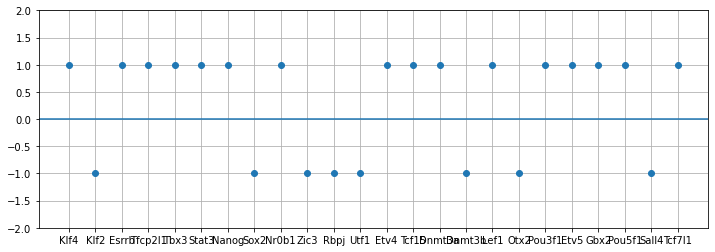

In [14]:
plt.figure(figsize=(12,4))
comparison=np.sign(logFC_Leeb)*np.sign(logFC_Leeb_t["Rbpj"])
plt.plot(comparison, "o")
plt.ylim([-2,2])
plt.grid()
plt.axhline(0)

print("In agreement:", len(np.where(comparison==1)[0])/24)
print("Not in agreement:", len(np.where(comparison==-1)[0])/24)

In [15]:
path_data

'/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/'

# Original data from Martin

In [16]:
# Load the excel file into a pandas dataframe
df_KO_N24 = pd.read_excel(path_data+'Leeb_Data_Orig/KOvsWT_N24_log2FCs_padj.xlsx', index_col=0, header=0, sheet_name='Log2FCs')


/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [17]:
df_KO_N24=df_KO_N24[df_KO_N24.index.isin(genes_order)].reindex(genes_order)


In [18]:
columns_Leeb=["N1_"+genes_order[ii] for ii in range(len(genes_order))]

common_cols = df_KO_N24.columns.intersection(columns_Leeb)
# Select only the common columns using the loc method
df_KO_N24_sel = df_KO_N24.loc[:, common_cols]

In [19]:
df_KO_N24_sel.columns=["Etv5","Rbpj", "Tcf7l1"]
col_order = ["Rbpj", "Etv5", "Tcf7l1"]
df_KO_N24_sel =df_KO_N24_sel.reindex(columns=col_order)
df_KO_N24_sel

,Rbpj,Etv5,Tcf7l1
Klf4,2.890194,2.386695,1.300426
Klf2,0.492426,1.008604,2.338680
Esrrb,2.391197,1.339748,2.123917
Tfcp2l1,2.672669,1.421478,2.395809
Tbx3,3.614621,3.088588,2.415481
Stat3,1.001716,0.364277,0.118663
Nanog,2.133909,2.424196,2.650496
Sox2,0.738636,0.540550,0.636951
Nr0b1,1.874182,0.637990,1.339980
Zic3,0.696761,-0.130455,0.975957


In [20]:
df_KO_N24_sel.shape


(24, 3)

## p-values

In [31]:
# Load the excel file into a pandas dataframe
df_KO_N24_pval = pd.read_excel(path_data+'Leeb_Data_Orig/KOvsWT_N24_log2FCs_padj.xlsx', index_col=0, header=0, sheet_name='padj')
df_KO_N24_pval=df_KO_N24_pval[df_KO_N24_pval.index.isin(genes_order)].reindex(genes_order)


/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [35]:
common_cols = df_KO_N24_pval.columns.intersection(columns_Leeb)
# Select only the common columns using the loc method
df_KO_N24_pval_sel = df_KO_N24_pval.loc[:, common_cols]


In [36]:
df_KO_N24_pval_sel.columns=["Etv5","Rbpj", "Tcf7l1"]
col_order = ["Rbpj", "Etv5", "Tcf7l1"]
df_KO_N24_pval_sel =df_KO_N24_pval_sel.reindex(columns=col_order)
df_KO_N24_pval_sel

,Rbpj,Etv5,Tcf7l1
Klf4,1.798158e-10,4.141961e-07,2.310206e-01
Klf2,1.000000e+00,4.217777e-01,3.480445e-09
Esrrb,5.826412e-10,1.969788e-02,1.230247e-07
Tfcp2l1,9.489153e-15,2.496669e-03,8.096539e-12
Tbx3,6.780885e-12,8.169721e-09,6.137712e-05
Stat3,4.016748e-02,1.000000e+00,1.000000e+00
Nanog,4.236607e-06,2.937113e-08,8.595298e-10
Sox2,8.156782e-01,1.000000e+00,1.000000e+00
Nr0b1,8.563960e-06,1.000000e+00,4.055363e-02
Zic3,1.000000e+00,1.000000e+00,1.273440e-01


In [37]:
df_KO_N24_sel[df_KO_N24_pval_sel>0.05]=0

In [41]:
save_data = True
if save_data:
    df_KO_N24_sel.to_csv(path_data+r'Leeb_Data_Orig/df_KO_N24_cleaned.csv',  sep=',', mode='w')

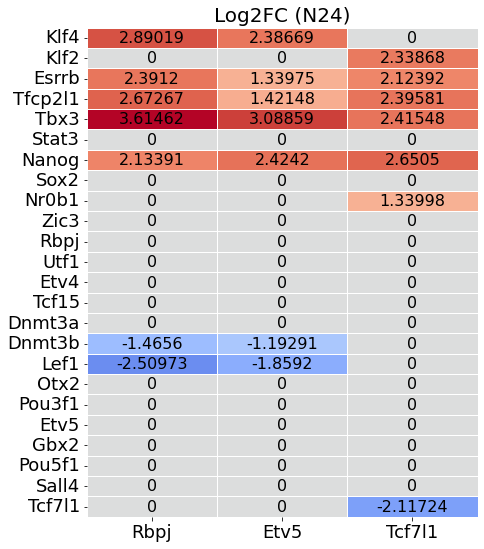

In [38]:

plt.figure(figsize=(7,9))
sns.heatmap(np.array(df_KO_N24_sel).astype(float), annot=True, fmt="g", 
            xticklabels=df_KO_N24_sel.columns, yticklabels=df_KO_N24_sel.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (N24)", fontsize=20)
plt.show()